In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# 1. Chargement des données
data = pd.read_csv('data.csv')
X = data.iloc[:, :2].values
y = data.iloc[:, -1].values.reshape(-1, 1)

# 2. Division des ensembles
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [3]:
# Fonctions utilitaires
def sigmoid(z):
    # Clip z values to avoid overflow
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def costFunctionReg(theta, X, y, lamda):
    m = y.shape[0]
    h = sigmoid(X.dot(theta))
    epsilon = 1e-5
    h = np.clip(h, epsilon, 1 - epsilon)
    cost = (-1/m) * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h))) + (lamda / (2 * m)) * np.sum(theta[1:] ** 2)
    return cost[0, 0]

def gradientDescent(X, y, theta, alpha, num_iters, lamda):
    m = y.shape[0]
    J_history = np.zeros(num_iters)
    for i in range(num_iters):
        h = sigmoid(X.dot(theta))
        gradient = (1 / m) * X.T.dot(h - y)
        gradient[1:] += (lamda / m) * theta[1:]
        theta -= alpha * gradient
        J_history[i] = costFunctionReg(theta, X, y, lamda)
    return theta, J_history

def predict(theta, X): 
    return (sigmoid(X.dot(theta)) >= 0.5).astype(int)

def accuracy(pred, y): 
    return np.mean(pred == y) * 100

def featureNormalize(X): 
    return (X - X.mean(axis=0)) / X.std(axis=0), X.mean(axis=0), X.std(axis=0)

def plotDecisionBoundary(theta, X, y, title="Frontière de décision"):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[y.flatten() == 0, 1], X[y.flatten() == 0, 2], s=100, c='b', marker='o', label='Classe 0')
    plt.scatter(X[y.flatten() == 1, 1], X[y.flatten() == 1, 2], s=100, c='r', marker='x', label='Classe 1')
    x1_min, x1_max = X[:, 1].min()-1, X[:, 1].max()+1
    x2 = (-theta[0][0] - theta[1][0]*x1_min) / theta[2][0], (-theta[0][0] - theta[1][0]*x1_max) / theta[2][0]
    plt.plot([x1_min, x1_max], list(x2), 'g-', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def learningCurve(X, y, Xval, yval, lamda, alpha, num_iters):
    m = X.shape[0]
    error_train, error_val = np.zeros(m), np.zeros(m)
    for i in range(1, m+1):
        X_subset, y_subset = X[:i], y[:i]
        theta = np.zeros((X.shape[1], 1))
        theta, _ = gradientDescent(X_subset, y_subset, theta, alpha, num_iters, lamda)
        error_train[i-1] = costFunctionReg(theta, X_subset, y_subset, 0)
        error_val[i-1] = costFunctionReg(theta, Xval, yval, 0)
    return error_train, error_val

def featurePolynomial(X, degree):
    X_poly = np.ones((X.shape[0], 1))
    for i in range(1, degree+1):
        for j in range(i+1):
            X_poly = np.hstack((X_poly, (X[:, 0]**(i-j) * X[:, 1]**j).reshape(-1, 1)))
    return X_poly

def validationCurve(X, y, Xval, yval, lambda_vec, alpha, num_iters):
    error_train, error_val = [], []
    theta_list = []
    for lamda in lambda_vec:
        theta = np.zeros((X.shape[1], 1))
        theta, _ = gradientDescent(X, y, theta, alpha, num_iters, lamda)
        theta_list.append(theta)
        error_train.append(costFunctionReg(theta, X, y, 0))
        error_val.append(costFunctionReg(theta, Xval, yval, 0))
    return np.array(error_train), np.array(error_val), lambda_vec[np.argmin(error_val)]

In [4]:
# Normalisation des données
X_train_n, mu, sigma = featureNormalize(X_train)
X_val_n = (X_val - mu) / sigma
X_train_b = np.hstack((np.ones((X_train_n.shape[0], 1)), X_train_n))
X_val_b = np.hstack((np.ones((X_val_n.shape[0], 1)), X_val_n))

In [5]:
# ---------------- LINEAR MODEL ----------------
alpha = 0.1
num_iters = 3000
lamda = 0
theta = np.zeros((X_train_b.shape[1], 1))
theta, J_history = gradientDescent(X_train_b, y_train, theta, alpha, num_iters, lamda)

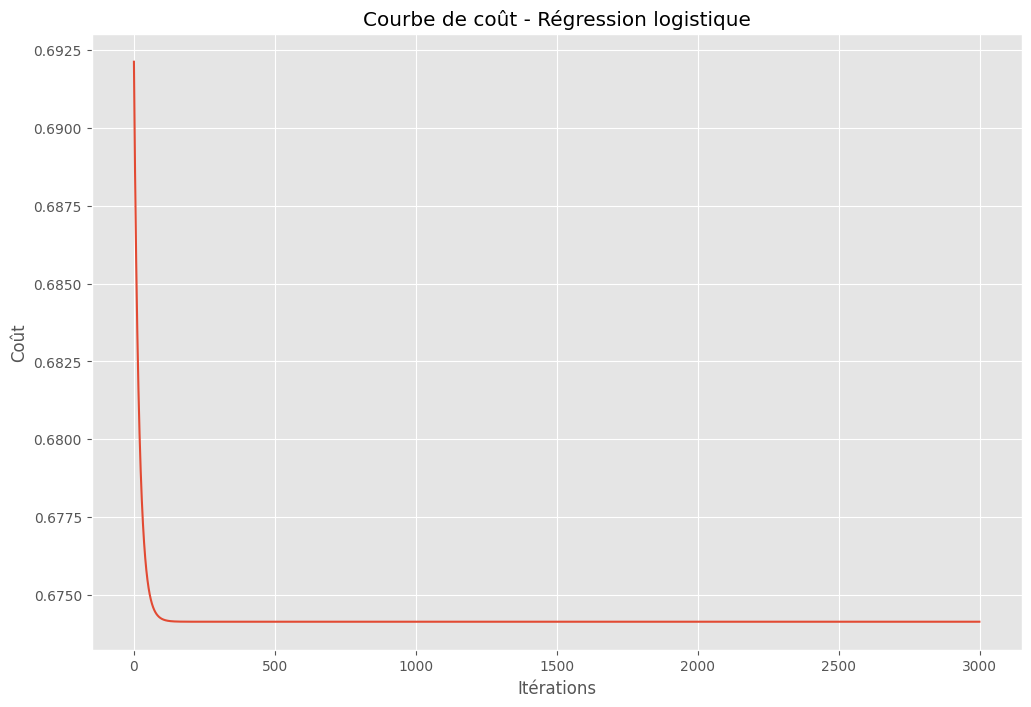

In [6]:
# Courbe de coût
plt.plot(range(num_iters), J_history)
plt.xlabel('Itérations')
plt.ylabel('Coût')
plt.title('Courbe de coût - Régression logistique')
plt.grid(True)
plt.show()

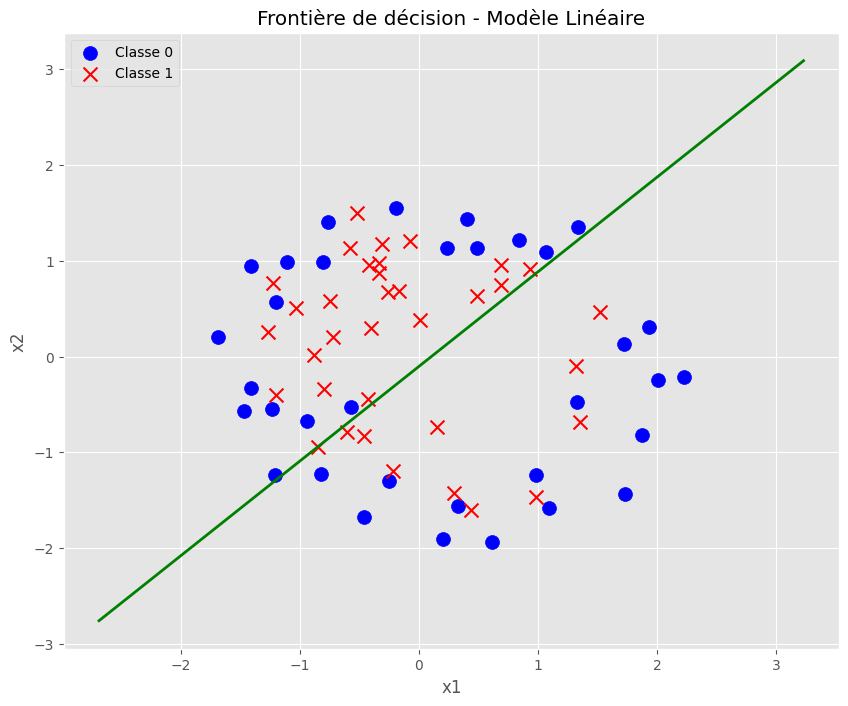

In [7]:
# Frontière de décision
plotDecisionBoundary(theta, X_train_b, y_train, "Frontière de décision - Modèle Linéaire")

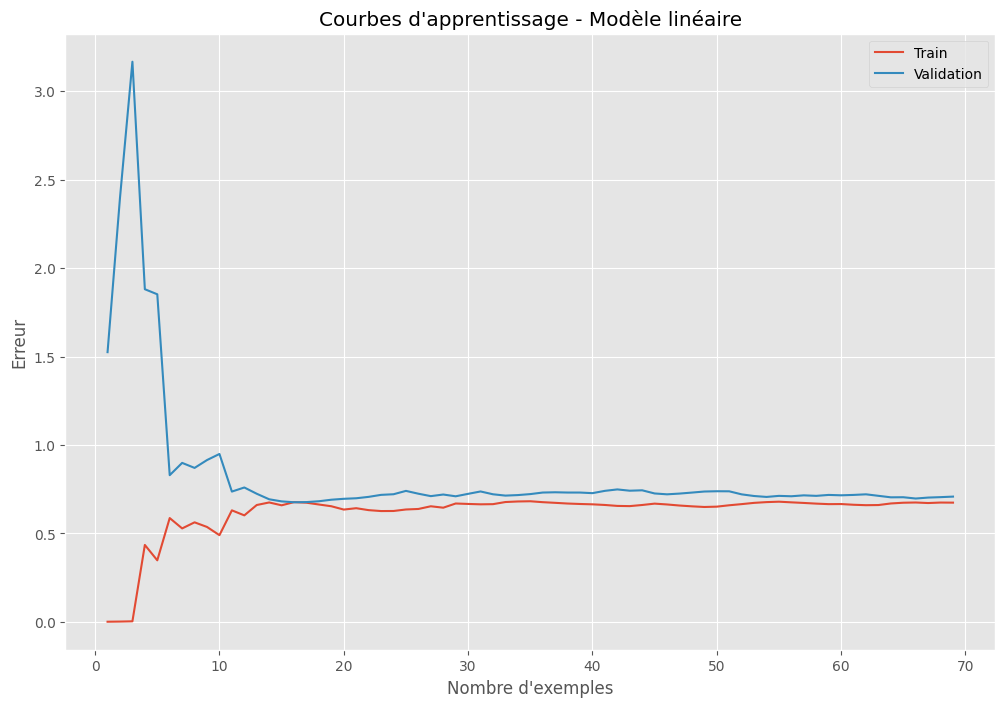

In [8]:
# Courbe d'apprentissage
error_train, error_val = learningCurve(X_train_b, y_train, X_val_b, y_val, lamda, alpha, num_iters)
plt.plot(range(1, len(error_train)+1), error_train, label="Train")
plt.plot(range(1, len(error_val)+1), error_val, label="Validation")
plt.title("Courbes d'apprentissage - Modèle linéaire")
plt.xlabel("Nombre d'exemples")
plt.ylabel("Erreur")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# ---------------- POLYNOMIAL MODEL ----------------
degree = 6
X_train_poly = featurePolynomial(X_train, degree)
X_val_poly = featurePolynomial(X_val, degree)
X_train_poly_n, mu_p, sigma_p = featureNormalize(X_train_poly[:, 1:])
X_val_poly_n = (X_val_poly[:, 1:] - mu_p) / sigma_p
X_train_poly_b = np.hstack((np.ones((X_train_poly_n.shape[0], 1)), X_train_poly_n))
X_val_poly_b = np.hstack((np.ones((X_val_poly_n.shape[0], 1)), X_val_poly_n))

In [10]:
# Préparation des données test pour le modèle polynomial
X_test_poly = featurePolynomial(X_test, degree)
X_test_poly_n = (X_test_poly[:, 1:] - mu_p) / sigma_p
X_test_poly_b = np.hstack((np.ones((X_test_poly_n.shape[0], 1)), X_test_poly_n))

theta_poly = np.zeros((X_train_poly_b.shape[1], 1))
theta_poly, _ = gradientDescent(X_train_poly_b, y_train, theta_poly, alpha, num_iters, lamda)

Frontière de décision - Modèle Polynomial


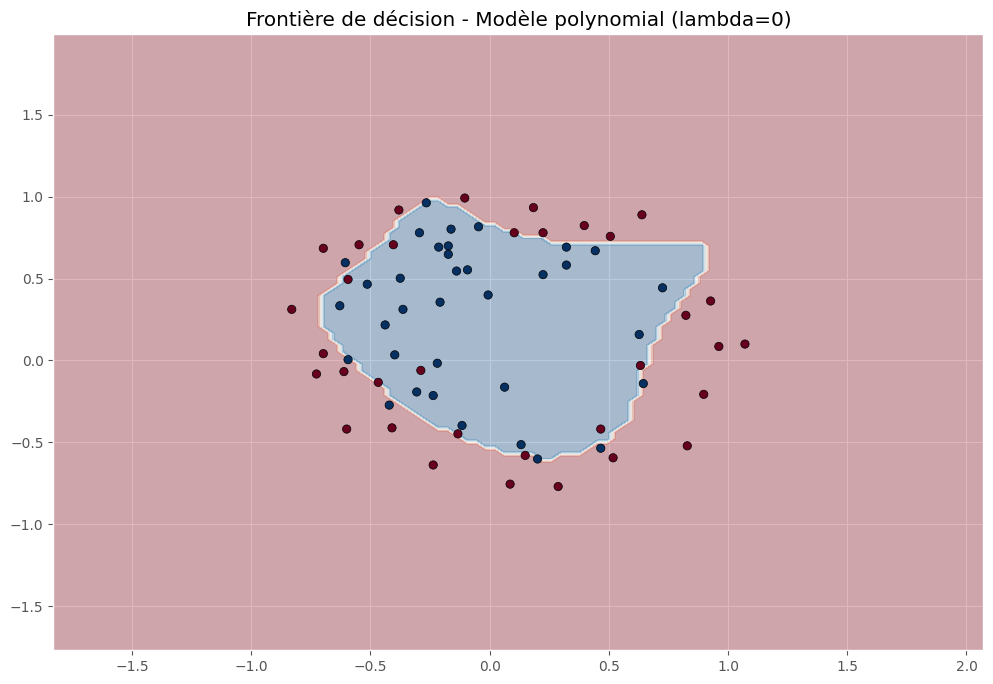

In [11]:
# Frontière de décision polynomiale
print("Frontière de décision - Modèle Polynomial")
x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
grid = np.c_[xx1.ravel(), xx2.ravel()]
grid_poly = featurePolynomial(grid, degree)
grid_poly_n = (grid_poly[:, 1:] - mu_p) / sigma_p
grid_poly_b = np.hstack((np.ones((grid_poly_n.shape[0], 1)), grid_poly_n))
Z = predict(theta_poly, grid_poly_b).reshape(xx1.shape)
plt.figure()
plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=plt.cm.RdBu)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(), cmap=plt.cm.RdBu, edgecolors='k')
plt.title("Frontière de décision - Modèle polynomial (lambda=0)")
plt.grid(True)
plt.show()

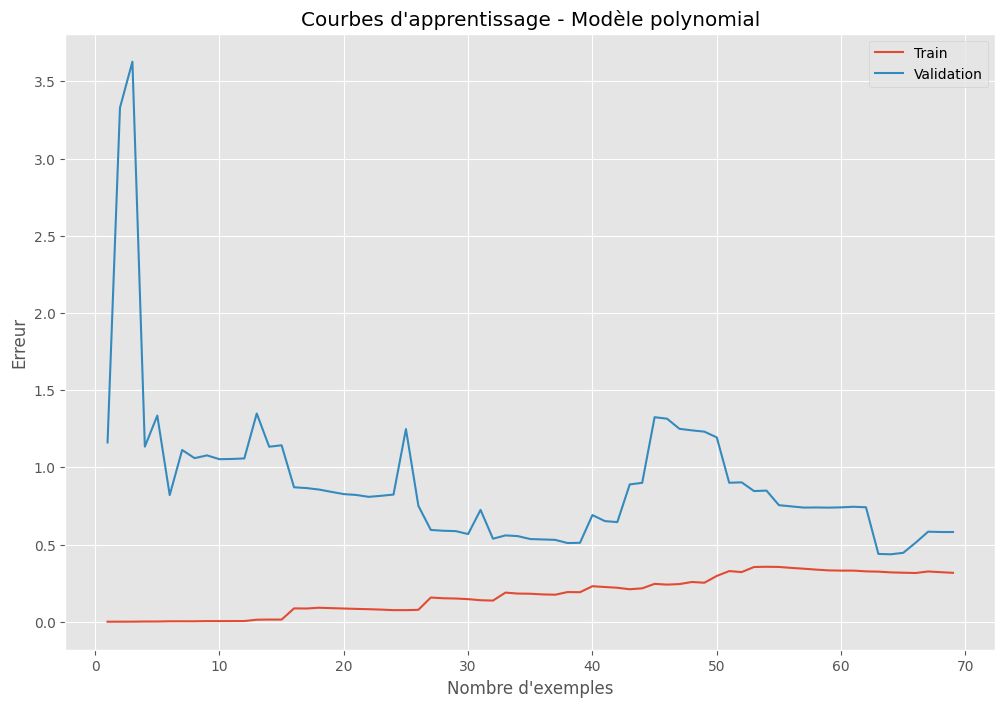

In [12]:
# Courbes d'apprentissage (poly)
error_train_p, error_val_p = learningCurve(X_train_poly_b, y_train, X_val_poly_b, y_val, 0, alpha, num_iters)
plt.plot(range(1, len(error_train_p)+1), error_train_p, label="Train")
plt.plot(range(1, len(error_val_p)+1), error_val_p, label="Validation")
plt.title("Courbes d'apprentissage - Modèle polynomial")
plt.xlabel("Nombre d'exemples")
plt.ylabel("Erreur")
plt.legend()
plt.grid(True)
plt.show()

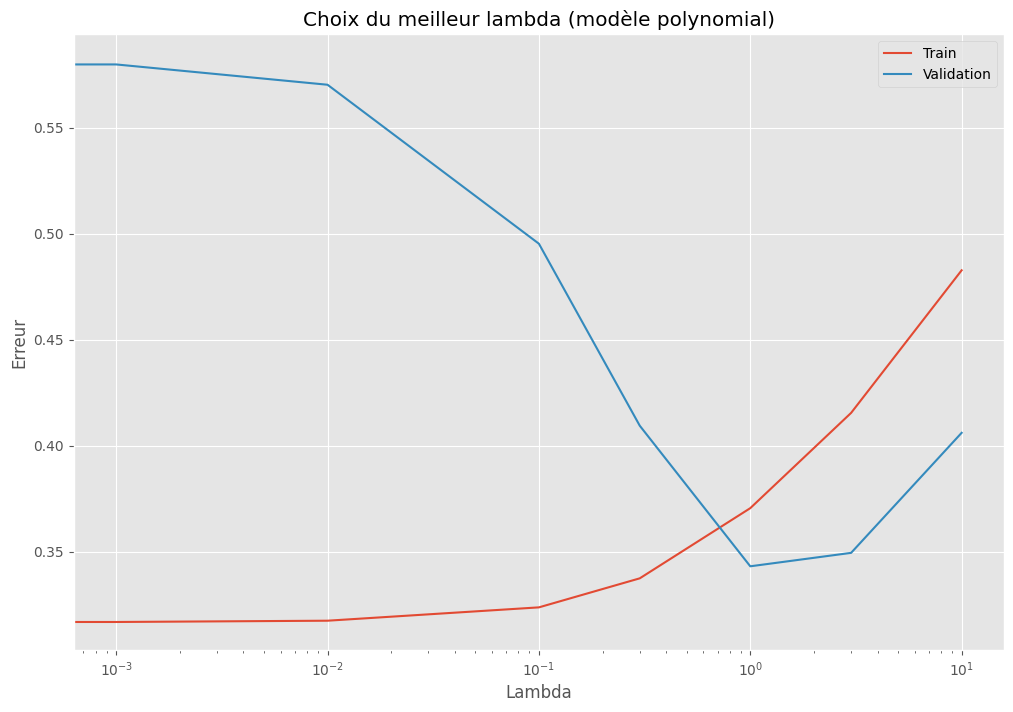

In [13]:
# Courbe lambda (validation curve)
lambda_vec = np.array([0, 0.001, 0.01, 0.1, 0.3, 1, 3, 10])
error_train_l, error_val_l, best_lamda = validationCurve(X_train_poly_b, y_train, X_val_poly_b, y_val, lambda_vec, alpha, num_iters)
plt.semilogx(lambda_vec, error_train_l, label="Train")
plt.semilogx(lambda_vec, error_val_l, label="Validation")
plt.xlabel("Lambda")
plt.ylabel("Erreur")
plt.title("Choix du meilleur lambda (modèle polynomial)")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
initial_theta = np.ones((X_train_poly_b.shape[1], 1))
lamb_optimal = 1  # You could use best_lamda from validation curve
alpha = 0.001
iterations = 10000

theta_optimal, J_history_poly = gradientDescent(X_train_poly_b, y_train, initial_theta, alpha, iterations, lamb_optimal)

test_error = costFunctionReg(theta_optimal, X_test_poly_b, y_test, 0)
print(f"The test error at the optimal lambda = {lamb_optimal} is equal to {test_error:.2f}")

The test error at the optimal lambda = 1 is equal to 0.46


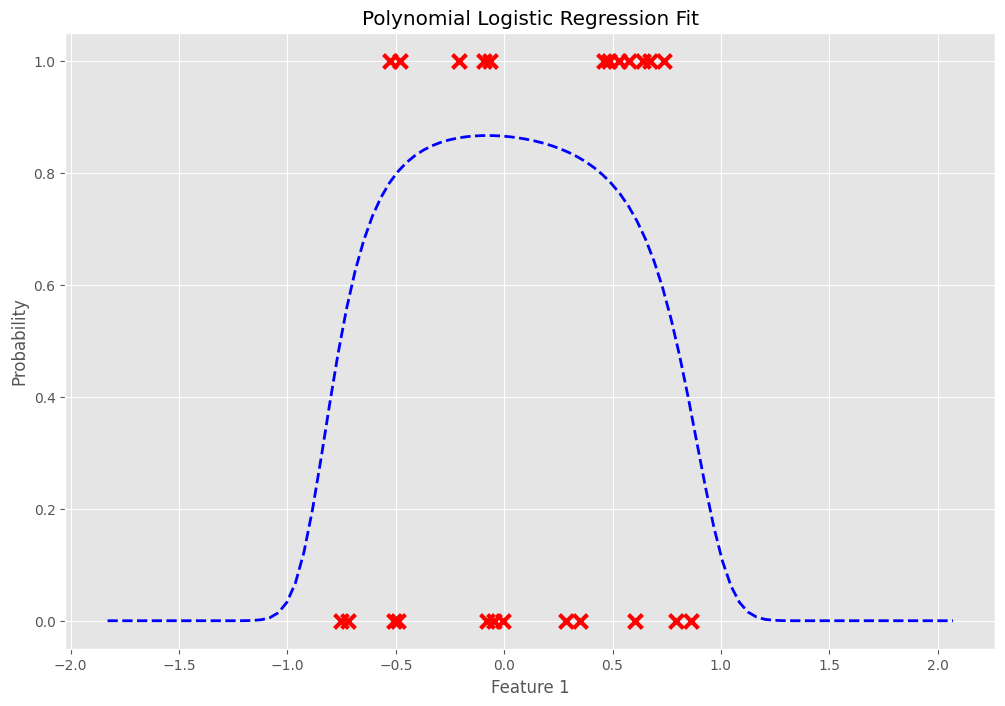

In [15]:
# Visualization for polynomial fit
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(X_test[:, 0], y_test, s=100, marker='x', color='r', linewidth=3)

# Create X values for plotting the polynomial curve
X_fit = np.linspace(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1, 100).reshape(-1, 1)
# Create a grid with the second feature set to constant values
X_fit_combined = np.hstack((X_fit, np.ones((X_fit.shape[0], 1)) * np.mean(X[:, 1])))
# Generate polynomial features
X_fit_poly = featurePolynomial(X_fit_combined, degree)
X_fit_poly_n = (X_fit_poly[:, 1:] - mu_p) / sigma_p
X_fit_poly_b = np.hstack((np.ones((X_fit_poly_n.shape[0], 1)), X_fit_poly_n))
# Calculate predictions
predictions = sigmoid(X_fit_poly_b.dot(theta_optimal))

ax.plot(X_fit, predictions, '--', color='blue', linewidth=2)
plt.xlabel('Feature 1')
plt.ylabel('Probability')
plt.title('Polynomial Logistic Regression Fit')
plt.grid(True)
plt.show()


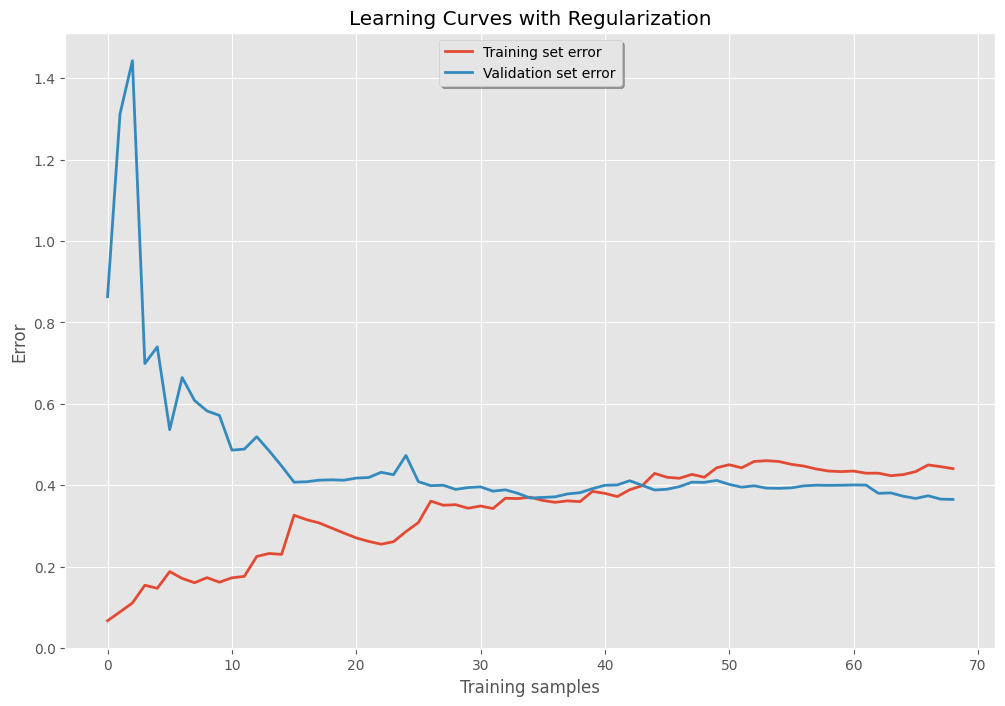

In [16]:
# Learning curves with optimal lambda
error_train_poly, error_val_poly = learningCurve(X_train_poly_b, y_train, X_val_poly_b, y_val, lamb_optimal, alpha, iterations)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(X_train_poly_b.shape[0]), error_train_poly, label='Training set error', linewidth=2)
ax.plot(range(X_train_poly_b.shape[0]), error_val_poly, label='Validation set error', linewidth=2)
ax.legend(loc='upper center', shadow=True)
plt.ylabel('Error')
plt.xlabel('Training samples')
plt.title('Learning Curves with Regularization')
plt.grid(True)
plt.show()